In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
# import pyedflib
import os
import glob
# import tensorflow as tf
from tqdm import tqdm
from lxml import etree
from sklearn.model_selection import train_test_split
import random

# Setup

In [2]:
BASE_DB_PATH = '/mnt/dat/databases/shhs/polysomnography'
TO_PATH = '/mnt/dat/prepped/apnea_sp02_pr_multiple'
os.makedirs(TO_PATH, exist_ok=True)

SAMPLING_RATE = 1.0 

SEGMENT_LENGTH = 150 # input to model
SINGLE_ANNOT = 30 # annotate for every 30s

HALF_SEGMENTS = (SEGMENT_LENGTH // SINGLE_ANNOT) // 2

SAMPLE_RECORD = 'shhs2-200078'

LONG_BADS = 500

MULTIPLE_PREPARE = 25 # 1 to ignore

SMALL_PORTION = 1 # get small portion of train/validation for debugging or tuning, 1 to ignore

# consider only below channels
SELECTED_CHANNELS = ['SaO2', 'H.R.', 'PR', 'OX stat', 'OX STAT']

In [3]:
shhs1_edfs = glob.glob(os.path.join(BASE_DB_PATH, 'edfs/shhs1/*.edf'))
shhs2_edfs = glob.glob(os.path.join(BASE_DB_PATH, 'edfs/shhs2/*.edf'))
shhs1_edfs = sorted(shhs1_edfs) # only get samples
shhs2_edfs = sorted(shhs2_edfs)

len(shhs1_edfs), len(shhs2_edfs)

(5793, 2651)

In [4]:
shhs1_xmls = glob.glob(os.path.join(BASE_DB_PATH, 'annotations-events-nsrr/shhs1/*.xml'))
shhs2_xmls = glob.glob(os.path.join(BASE_DB_PATH, 'annotations-events-nsrr/shhs2/*.xml'))
shhs1_xmls = sorted(shhs1_xmls)
shhs2_xmls = sorted(shhs2_xmls)

len(shhs1_xmls), len(shhs2_xmls)

(5793, 2651)

# Examine a sample record

In [5]:
def get_edf(path, channels, preload=False):
    return mne.io.read_raw_edf(path, include=channels, 
                               verbose=False, preload=preload)

In [6]:
edf = get_edf([s for s in shhs1_edfs +  shhs2_edfs if SAMPLE_RECORD in s][0], SELECTED_CHANNELS)

33300


<Axes: >

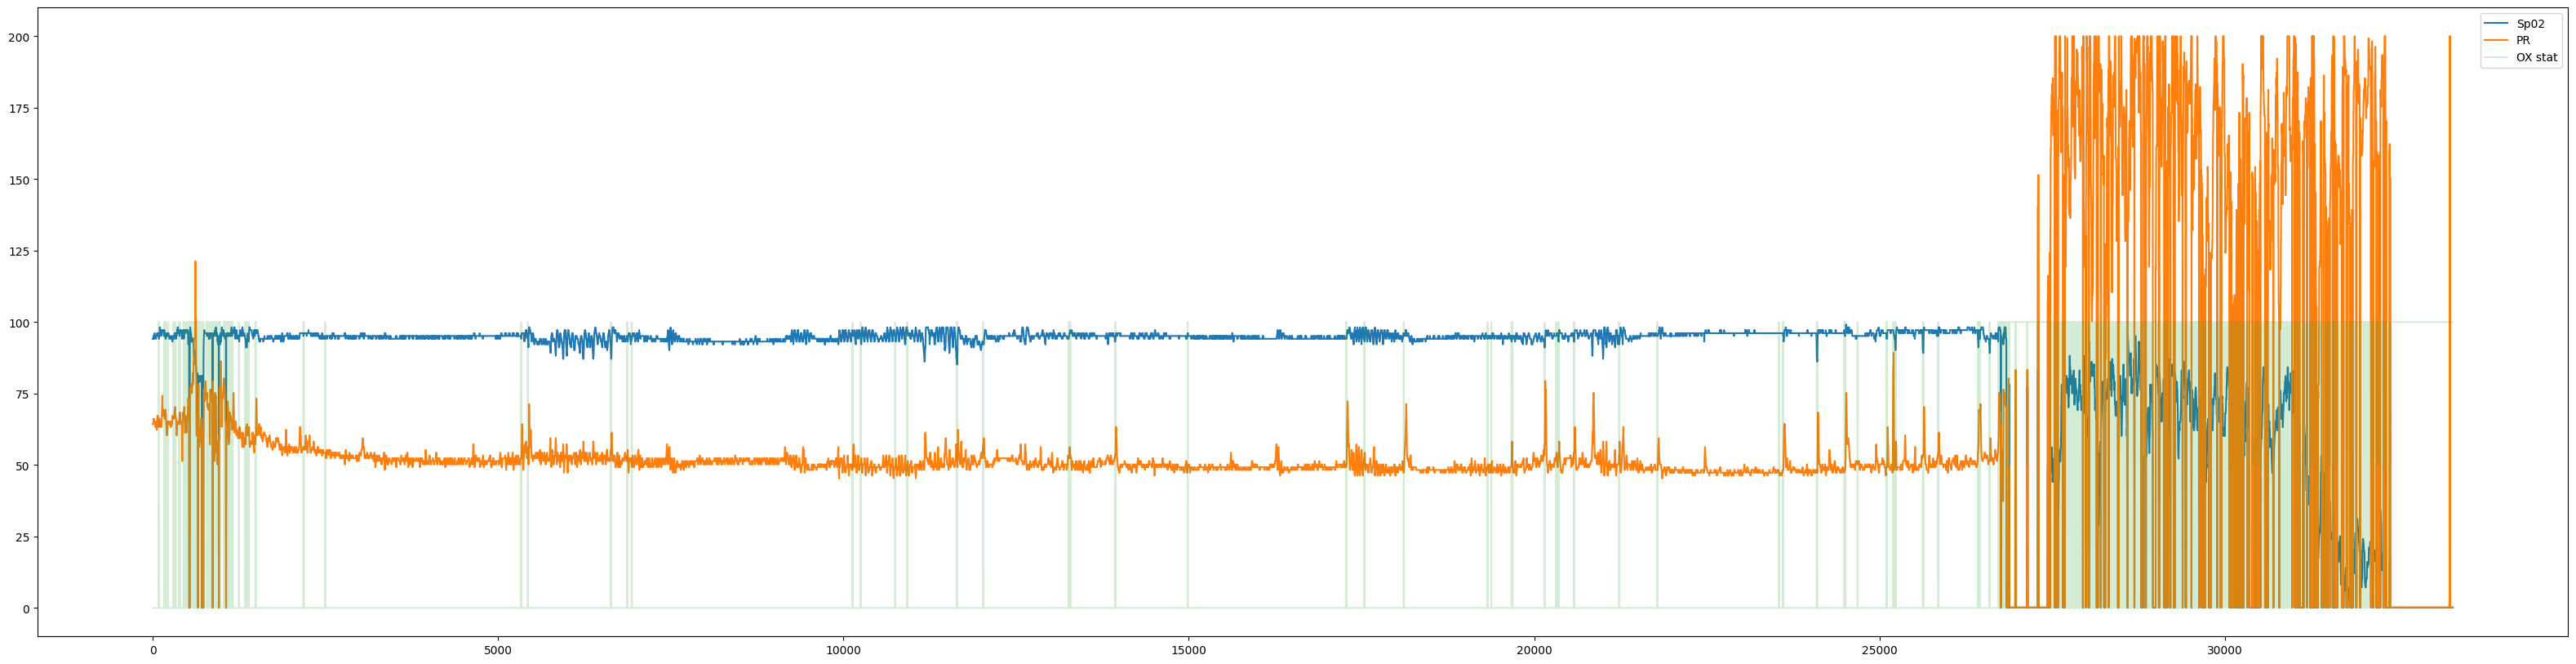

In [7]:
dataa1 = edf.get_data()
print(len(dataa1[1]))
plt.figure(figsize=(40, 10))
sns.lineplot(dataa1[0], label='Sp02')
sns.lineplot(dataa1[1], label='PR')
sns.lineplot(dataa1[2] * 50, label='OX stat', alpha=0.2)

# Read annotation

In [8]:
import logging
# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def create_annotation(xml_path, start_date, selected_channels):
    # Use lxml's fast parser
    parser = etree.XMLParser(remove_blank_text=True, collect_ids=False)
    
    # Use xpath for direct access to elements
    try:
        tree = etree.parse(xml_path, parser)
    except (etree.XMLSyntaxError, OSError) as e:
        raise ValueError(f"Error parsing XML file: {e}")
    
    onset = []
    duration = []
    description = []
    ch_names = []
    
    for event in tree.xpath(".//ScoredEvent"):
        event_name = event.find('EventConcept').text
        ch_name = event.find('SignalLocation')
        if ch_name is None:
            ch_name = []
        elif ch_name.text in selected_channels:
            ch_name = [ch_name.text]
        else:
            ch_name = [] # or ignore by continue

        try:
            start_time = float(event.findtext('Start', default="0.0"))
            sduration = float(event.findtext('Duration', default="0.0"))
        except ValueError:
            logger.warning(f"Invalid start time or duration in event: {etree.tostring(event, pretty_print=True).decode()}")
            continue
        
        onset.append(start_time)
        duration.append(sduration)
        description.append(event_name)
        ch_names.append(ch_name)
    return mne.Annotations(onset=onset, duration=duration, description=description, ch_names=ch_names, orig_time=start_date)

In [9]:
anott = create_annotation([s for s in shhs1_xmls + shhs2_xmls if SAMPLE_RECORD in s][0], edf.info['meas_date'], SELECTED_CHANNELS)

edf = edf.set_annotations(anott, emit_warning=False)

anott.to_data_frame()

onset  duration                  description ch_names
0   1985-01-01 23:15:00.000    1980.0                       Wake|0       ()
1   1985-01-01 23:15:00.000   33300.0         Recording Start Time       ()
2   1985-01-01 23:23:48.000      10.0  SpO2 artifact|SpO2 artifact  (SaO2,)
3   1985-01-01 23:25:51.000       5.0  SpO2 artifact|SpO2 artifact  (SaO2,)
4   1985-01-01 23:26:50.000      11.0  SpO2 artifact|SpO2 artifact  (SaO2,)
..                      ...       ...                          ...      ...
604 1985-01-02 07:52:35.000       5.0  SpO2 artifact|SpO2 artifact  (SaO2,)
605 1985-01-02 07:52:50.000       3.0  SpO2 artifact|SpO2 artifact  (SaO2,)
606 1985-01-02 07:52:55.800     606.2  SpO2 artifact|SpO2 artifact  (SaO2,)
607 1985-01-02 08:03:02.000    1200.0  SpO2 artifact|SpO2 artifact  (SaO2,)
608 1985-01-02 08:23:02.000     423.4  SpO2 artifact|SpO2 artifact  (SaO2,)

[609 rows x 4 columns]

In [10]:
anott.to_data_frame()['onset'].max()

Timestamp('1985-01-02 08:23:02')

# Preprocess

## Interpolate bad samples

In [11]:
import numpy as np

def extract_consecutive_segments(cond):
    # Identify changes in the mask to detect segment boundaries
    diff = np.diff(cond.astype(int))
    starts = np.where(diff == 1)[0] + 1  # Start indices
    ends = np.where(diff == -1)[0] + 1   # End indices
    
    # Handle edge cases where the mask starts or ends with True
    if cond[0]:
        starts = np.insert(starts, 0, 0)
    if cond[-1]:
        ends = np.append(ends, len(cond))
    
    # Extract segments
    return starts, ends

# Example Usage
array = np.array([1, 2, 2, 3, 2, 2, 2, 4, 2, 2, 3])
indices = extract_consecutive_segments(array == 2)
print("Segment Indices:", indices)


Segment Indices: (array([1, 4, 8]), array([ 3,  7, 10]))


In [12]:
def interpolate_bad_samples(raw: mne.io.Raw):
    # assume order: Sp02, PR, OX stat
    signal_picks = [0, 1] 
    ox_channel = [2]
    # Extract the data
    data = raw.get_data()
    ox_data = data[ox_channel, :].flatten()
    
    condition = ((ox_data > 0) | # bad OX stat
                 ((data[0, :] < 70) | (data[0, :] > 100)) | # SpO2 outside 70-100% range
                 ((data[1, :] < 40) | (data[1, :] > 150))) # PR outside 40-150 
    
    start_bad, end_bad = extract_consecutive_segments(ox_data == 2)
    ignore_long_bads = [s for s in zip(start_bad, end_bad) if s[1] - s[0] >= LONG_BADS]
    # for start, stop in ignore_long_bads:
    #     condition[start:stop] = 0

    bad_indices = np.where(condition)[0] 
    
    for idx in signal_picks:
        signal_data = data[idx, :]

        good_indices = np.setdiff1d(np.arange(len(signal_data)), bad_indices)

        # Interpolate bad values
        signal_data[bad_indices] = np.interp(
            bad_indices, good_indices, signal_data[good_indices]
        )

        data[idx, :] = signal_data

    return data[signal_picks, :], np.array(ignore_long_bads)

(2, 33300) [[32390 33300]]


<Axes: >

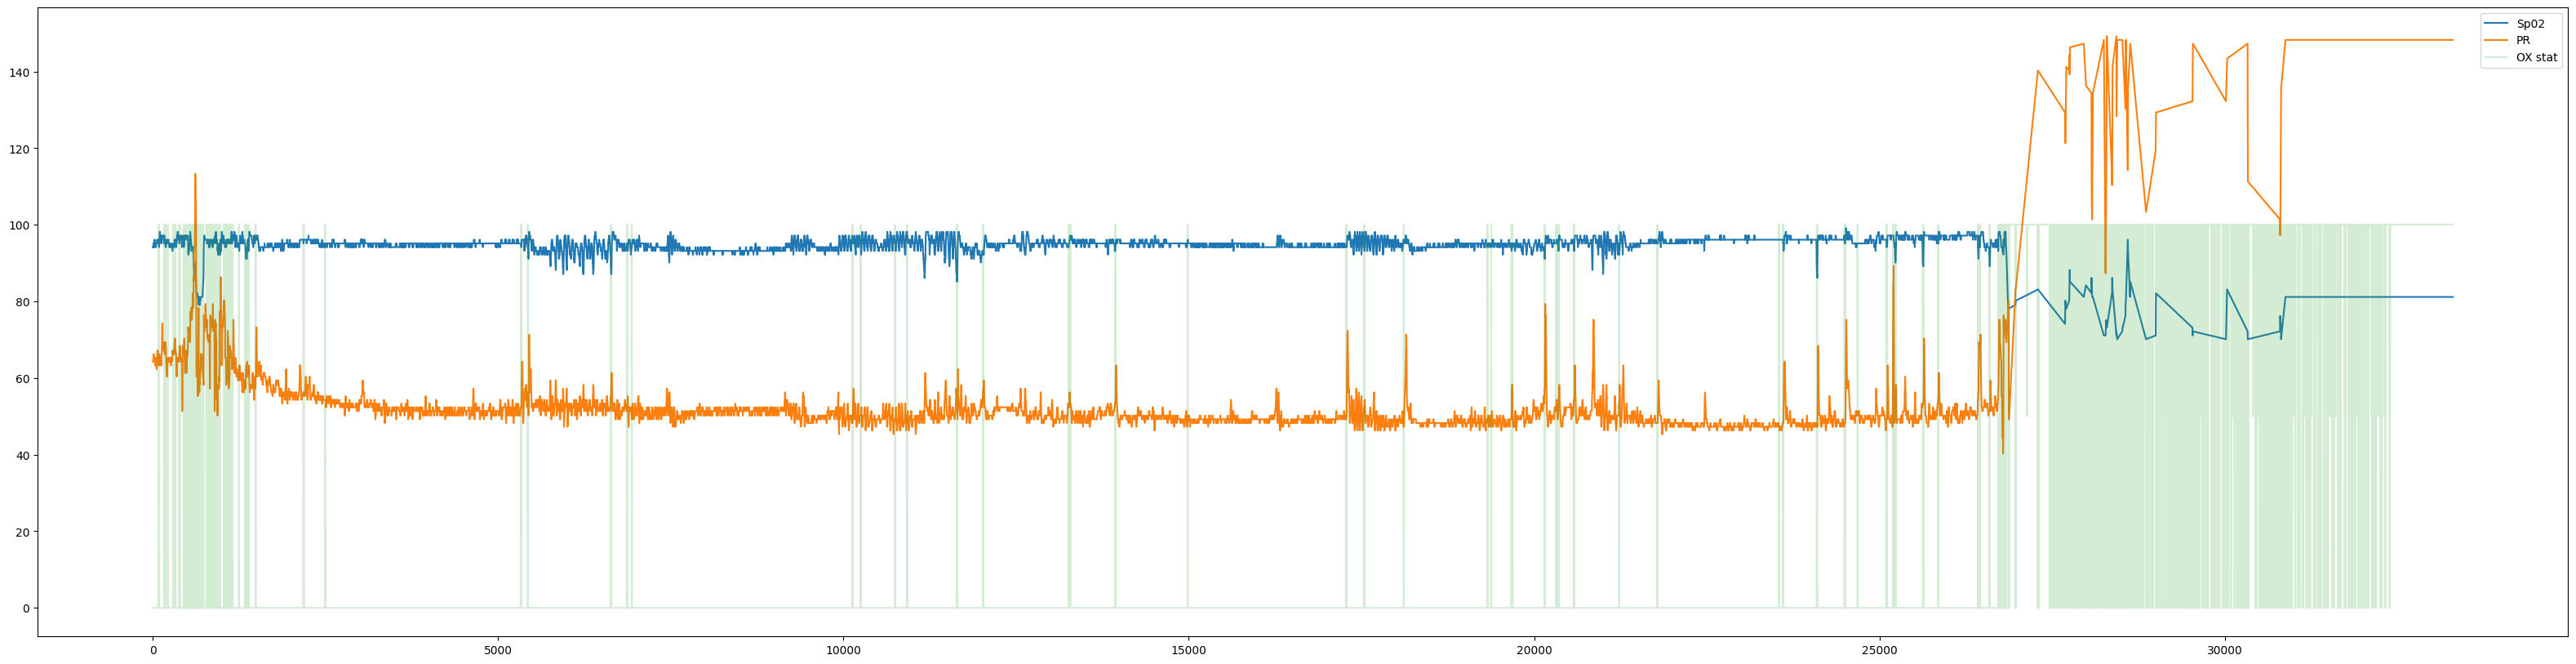

In [13]:
dataa, long_bads = interpolate_bad_samples(edf)
print(dataa.shape, long_bads)
plt.figure(figsize=(40, 10))

sns.lineplot(dataa[0], label='Sp02')
sns.lineplot(dataa[1], label='PR')
sns.lineplot((dataa1[2] * 50), label='OX stat', alpha=0.2)

## Standardize 

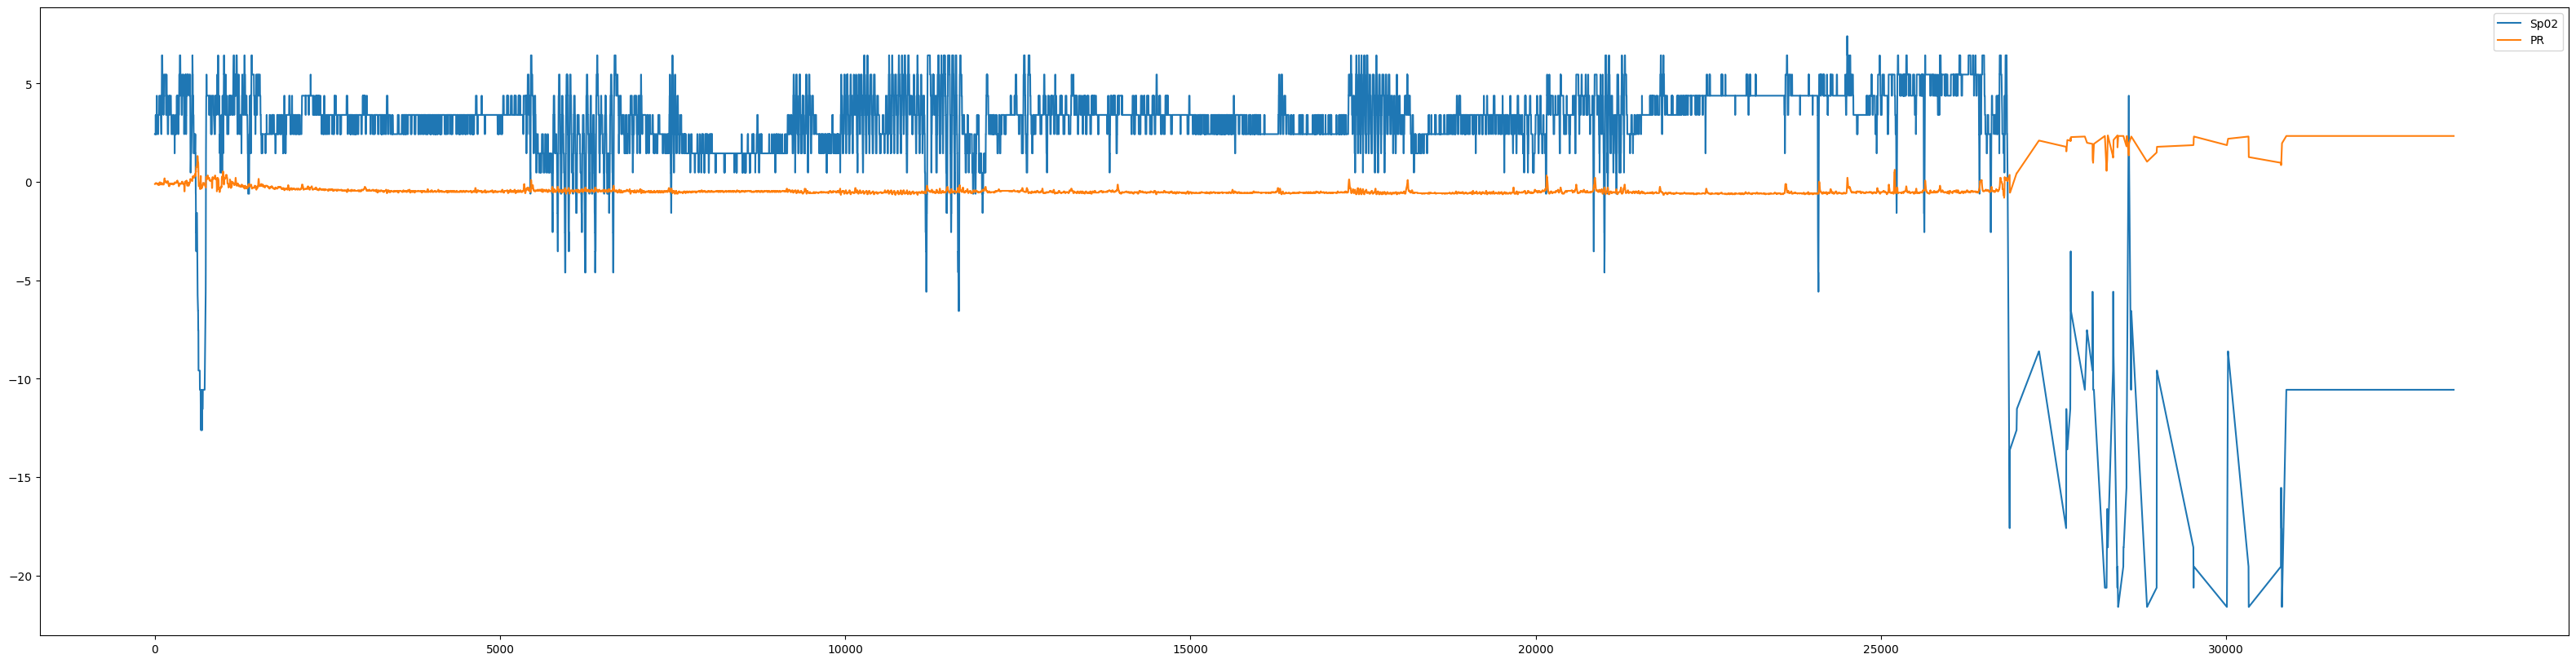

In [14]:
def standardize(sig: np.ndarray):
    return (sig - sig.mean()) / sig.std()

def sub_mean(sig: np.ndarray):
    return sig - sig.mean()


plt.figure(figsize=(40, 10))
sns.lineplot(sub_mean(dataa[0]), label='Sp02')
sns.lineplot(standardize(dataa[1]), label='PR')
plt.show()

## Desaturation

In [15]:
import numpy as np

def detect_desaturation_events(
    SpO2, 
    sampling_rate=1, 
    SpO2drop=2.9,  # A SpO2drop value of 2.9%
    window_baseline=60, # previous 60 s window
    event_duration=30, # if a drop ≥ SpO2drop from baseline (SpO2baseline ) occurs in the next 30 s
    max_event_duration=120 # event end: 3) 120 s
):
    """
    Detect desaturation events in SpO₂ data based on dynamic nadir calculation.
    
    Parameters:
    - SpO2: numpy array of SpO₂ values.
    - sampling_rate: Number of samples per second.
    - SpO2drop: Minimum drop from baseline to consider an event.
    - window_baseline: Baseline window size (in seconds).
    - event_duration: Duration to check for a drop (in seconds).
    - max_event_duration: Maximum allowed event duration (in seconds).
    
    Returns:
    - List of dictionaries with event start, end, and details.
    """
    baseline_samples = int(window_baseline * sampling_rate)
    event_samples = int(event_duration * sampling_rate)
    max_event_samples = int(max_event_duration * sampling_rate)
    
    onset = []
    offset = []
    
    slopes = np.diff(SpO2, prepend=SpO2[0])
    
    i = baseline_samples  # Start after the first baseline window
    while i < len(SpO2) - event_samples:
        # Calculate SpO2baseline (mean of previous baseline_samples)
        SpO2baseline = np.mean(SpO2[i - baseline_samples:i])
        
        # Check for drops in the next event_duration
        future_window = SpO2[i:i + event_samples]
        nadir_index = np.argmin(future_window)
        nadir_value = future_window[nadir_index]
        
        drop = SpO2baseline - future_window
        
        # slope
        cur_slopes = slopes[i:i + event_samples]
        cur_slopes = cur_slopes[cur_slopes.nonzero()[0]] # not consider plateau here
        sl_cond = cur_slopes <= -0.1 # with a slope ≥ 0.1% per second 
        
        if np.all(drop >= SpO2drop) and len(sl_cond) != 0 and np.all(sl_cond):
            event_start = i
            
            # Event end based on conditions
            for j in range(event_start + 1, min(len(SpO2), 
                                                event_start + max_event_samples)): # Condition 3: Max duration
                event_end = j
                if (
                    SpO2[j] >= SpO2baseline - 1  # Condition 1: Returns to baseline - 1
                    or SpO2[j] >= 1.5 * nadir_value  # Condition 2: Reaches 1.5 × nadir
                ):
                    break
            
            # Append the detected event
            onset.append(event_start)
            offset.append(event_end)
            
            i = event_end
            continue
        
        i += 1
    
    return onset, offset


# Example Usage
SpO2 = dataa[0]

on_pred, off_pred = detect_desaturation_events(SpO2)

In [16]:
def get_onset_offset(annot: mne.Annotations, label: str):
    adf = annot.to_data_frame()
    adf['lower_desc'] = adf['description'].str.lower()
    selected_df = adf[adf['lower_desc'].str.contains(label)].copy()
    start_time = adf[adf['description'].str.contains('Recording Start Time')]['onset'].iloc[0]

    startt = (selected_df["onset"] - start_time).dt.total_seconds().astype(int)
    off = (startt + selected_df["duration"]).astype(int)
    return startt, off


# annotated desaturation (should be ignored according to: https://ieeexplore.ieee.org/document/8322241/)
onsett, offsett = get_onset_offset(edf.annotations, 'desat')

In [17]:
import plotly.graph_objects as go


def plot_compare_anot(y_data, second_channel=None, 
                      bads=[], 
                      on_pred=[], off_pred=[], on_true=[], off_true=[], 
                      labels=[], 
                      name=None):
    assert len(on_pred) == len(off_pred) and len(on_true) == len(off_true)
    
    # Create the line plot
    fig = go.Figure()

    # Add the main line
    fig.add_trace(go.Scatter(x=list(range(len(y_data))), y=y_data, mode="lines", name="SpO2", line=dict(color="black", width=2, dash="solid")))

    if second_channel is not None:
        fig.add_trace(go.Scatter(x=list(range(len(y_data))), y=second_channel, mode="lines", name="HR", line=dict(color="purple", width=2, dash="solid")))
    
    # Add highlighted intervals
    for start, end in zip(on_pred, off_pred):
        fig.add_shape(
            type="rect",
            x0=start,
            x1=end,
            y0=y_data.min(),
            y1=y_data.max(),
            fillcolor="red",  # Semi-transparent red
            opacity=0.5,
            line_width=0,
        )

    for onset, offset in zip(on_true, off_true):
        fig.add_shape(
            type="rect",
            x0=onset,
            x1=offset,
            y0=y_data.min(),
            y1=y_data.max(),
            fillcolor="green",  # Semi-transparent blue
            opacity=0.4,
            line_width=0,
        )

    for bad_start, bad_end in bads:
        fig.add_shape(
            type="rect",
            x0=bad_start,
            x1=bad_end,
            y0=y_data.min(),
            y1=y_data.max(),
            fillcolor="yellow",  # Semi-transparent yellow
            opacity=0.3,
            line_width=0,
        )

    for i, label in enumerate(labels):
        if label == 1:
            fig.add_shape(
                type="rect",
                x0=i * SINGLE_ANNOT,
                x1=(i + 1) * SINGLE_ANNOT,
                y0=y_data.min() - 10,
                y1=y_data.max() + 10,
                fillcolor="blue",
                opacity=0.5,
                line_width=0,
            )

    # Customize layout
    fig.update_layout(
        title=name,
        xaxis_title="Time",
        yaxis_title="Amplitude",
        showlegend=False,
    )

    fig.show()
    
    # # Create a figure
    # plt.figure(figsize=(40, 10))

    # # Plot the main channel
    # plt.plot(range(len(y_data)), y_data, label="SpO2", color="black", linewidth=2, linestyle="solid")

    # # Plot the second channel if provided
    # if second_channel is not None:
    #     plt.plot(range(len(second_channel)), second_channel, label="HR", color="purple", linewidth=2, linestyle="solid")

    # # Highlight predicted intervals
    # for start, end in zip(on_pred, off_pred):
    #     plt.axvspan(start, end, color="red", alpha=0.5)

    # # Highlight true intervals
    # for onset, offset in zip(on_true, off_true):
    #     plt.axvspan(onset, offset, color="green", alpha=0.4)

    # # Customize the plot
    # plt.title("Line Plot with Highlighted Intervals")
    # plt.xlabel("Time")
    # plt.ylabel("Amplitude")
    # plt.legend()
    # plt.grid(True)

    # # Save and show the plot
    # plt.tight_layout()
    # plt.show()





plot_compare_anot(dataa[0], dataa[1], long_bads, on_pred, off_pred, onsett, offsett, [], name=SAMPLE_RECORD)

# Split to segments

In [18]:
def split_array(arr, axis, single_segment_len):
    num_segments = arr.shape[axis] // single_segment_len
    trimmed_array = arr[:, :num_segments * single_segment_len] # drop last
    res = np.split(trimmed_array, num_segments, axis=axis)
    res = np.array(res)
    return res


splitted_data = split_array(dataa, 1, SINGLE_ANNOT)
splitted_data.shape

(1110, 2, 30)

# Assign label

1) If an epoch contains an entire apnea event, it is labeled positive;
2) If an event spans across multiple epochs, the first epoch is positive if at least 50% of the epoch has apnea, the last epoch is positive if at least 50% has apnea or if the first epoch has < 50% apnea; 
3) Any intermediate epochs, if present, are positive.

In [19]:
def assign_apnea(onset, offset, num_epochs, epoch_len): # 30s epoch
    label = np.zeros(num_epochs, dtype=int)
    for on, off in zip(onset, offset):
        epoch_on_i = on // epoch_len
        epoch_off_i = (off - 1) // epoch_len
        
        spans = epoch_off_i - epoch_on_i + 1
        
        if spans == 1: # entire
            label[epoch_on_i] = 1
        else:
            if spans > 2: # intermediate
                label[epoch_on_i + 1:epoch_off_i] = 1
            if (epoch_on_i + 1) * epoch_len - on >= 0.5 * epoch_len: # half start
                label[epoch_on_i] = 1
            if off - (epoch_off_i * epoch_len - 1) >= 0.5 * epoch_len: # half end
                label[epoch_off_i] = 1

    return label

onset, offset = get_onset_offset(edf.annotations, 'apnea')
label = assign_apnea(onset, offset, splitted_data.shape[0], splitted_data.shape[2])

plot_compare_anot(dataa[0], dataa[1], long_bads, [], [], onset, offset, label, name=SAMPLE_RECORD)

## Consider desaturations

Hypopnea with arousal and hypopnea with 3% desaturation

In [20]:
# not used yet

# Multiprocess data preparing

In [21]:
all_record = {}

for path in shhs1_xmls + shhs2_xmls:
    record = path[path.rfind("/") + 1:path.rfind("-nsrr.xml")]
    all_record[record] = [None, path]

for path in shhs1_edfs + shhs2_edfs:
    record = path[path.rfind("/") + 1:path.rfind(".edf")]
    all_record[record][0] = path
    
all_record = pd.DataFrame(all_record).T
all_record.index.name = 'Record'
all_record = all_record.rename(columns={0: 'EDF_path', 1: 'XML_path'})
all_record.reset_index(inplace=True)
all_record

Record                                           EDF_path  \
0     shhs1-200001  /mnt/dat/databases/shhs/polysomnography/edfs/s...   
1     shhs1-200002  /mnt/dat/databases/shhs/polysomnography/edfs/s...   
2     shhs1-200003  /mnt/dat/databases/shhs/polysomnography/edfs/s...   
3     shhs1-200004  /mnt/dat/databases/shhs/polysomnography/edfs/s...   
4     shhs1-200005  /mnt/dat/databases/shhs/polysomnography/edfs/s...   
...            ...                                                ...   
8439  shhs2-205786  /mnt/dat/databases/shhs/polysomnography/edfs/s...   
8440  shhs2-205796  /mnt/dat/databases/shhs/polysomnography/edfs/s...   
8441  shhs2-205797  /mnt/dat/databases/shhs/polysomnography/edfs/s...   
8442  shhs2-205798  /mnt/dat/databases/shhs/polysomnography/edfs/s...   
8443  shhs2-205800  /mnt/dat/databases/shhs/polysomnography/edfs/s...   

                                               XML_path  
0     /mnt/dat/databases/shhs/polysomnography/annota...  
1     /mnt/dat/databases/shhs/polysomnography/annota...  
2     /mnt/dat/databases/shhs/polysomnography/annota...  
3     /mnt/dat/databases/shhs/polysomnography/annota...  
4     /mnt/dat/databases/shhs/polysomnography/annota...  
...                                                 ...  
8439  /mnt/dat/databases/shhs/polysomnography/annota...  
8440  /mnt/dat/databases/shhs/polysomnography/annota...  
8441  /mnt/dat/databases/shhs/polysomnography/annota...  
8442  /mnt/dat/databases/shhs/polysomnography/annota...  
8443  /mnt/dat/databases/shhs/polysomnography/annota...  

[8444 rows x 3 columns]

In [22]:
# remove missing records with missing channel (must contain SpO2, HR, OX stat)
remove_rows = []
for i, row in tqdm(all_record.iterrows(), total=len(all_record)):
    if row['EDF_path'] is None or row['XML_path'] is None:
        remove_rows.append(i)
        continue
    edf = get_edf(row['EDF_path'], SELECTED_CHANNELS, preload=False)
    if len(edf.ch_names) < 3: 
        remove_rows.append(i)
        continue

all_record.drop(index=remove_rows, inplace=True)
all_record

100%|██████████| 8444/8444 [01:14<00:00, 112.77it/s]


Record                                           EDF_path  \
0     shhs1-200001  /mnt/dat/databases/shhs/polysomnography/edfs/s...   
1     shhs1-200002  /mnt/dat/databases/shhs/polysomnography/edfs/s...   
2     shhs1-200003  /mnt/dat/databases/shhs/polysomnography/edfs/s...   
3     shhs1-200004  /mnt/dat/databases/shhs/polysomnography/edfs/s...   
4     shhs1-200005  /mnt/dat/databases/shhs/polysomnography/edfs/s...   
...            ...                                                ...   
8439  shhs2-205786  /mnt/dat/databases/shhs/polysomnography/edfs/s...   
8440  shhs2-205796  /mnt/dat/databases/shhs/polysomnography/edfs/s...   
8441  shhs2-205797  /mnt/dat/databases/shhs/polysomnography/edfs/s...   
8442  shhs2-205798  /mnt/dat/databases/shhs/polysomnography/edfs/s...   
8443  shhs2-205800  /mnt/dat/databases/shhs/polysomnography/edfs/s...   

                                               XML_path  
0     /mnt/dat/databases/shhs/polysomnography/annota...  
1     /mnt/dat/databases/shhs/polysomnography/annota...  
2     /mnt/dat/databases/shhs/polysomnography/annota...  
3     /mnt/dat/databases/shhs/polysomnography/annota...  
4     /mnt/dat/databases/shhs/polysomnography/annota...  
...                                                 ...  
8439  /mnt/dat/databases/shhs/polysomnography/annota...  
8440  /mnt/dat/databases/shhs/polysomnography/annota...  
8441  /mnt/dat/databases/shhs/polysomnography/annota...  
8442  /mnt/dat/databases/shhs/polysomnography/annota...  
8443  /mnt/dat/databases/shhs/polysomnography/annota...  

[8075 rows x 3 columns]

In [23]:
import tensorflow as tf

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode('utf-8')]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _int64_feature(value):
    """Returns an int64_list from an integer or list of integers."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def serialize_example(ext, label, name=None):
    """Serialize the X and y data into a TFRecord example."""
    feature = {'ext': _float_feature(ext.flatten())}
    
    if label is not None:
        feature['label'] = _int64_feature(label.flatten())
    if name is not None:
        feature['name'] = _bytes_feature(name)
        
    return tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()


2024-12-02 15:43:17.807515: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 15:43:17.900366: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733128997.938184    7803 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733128997.948426    7803 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-02 15:43:18.036946: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [24]:
OPTIONS = tf.io.TFRecordOptions(compression_type="GZIP")

In [25]:
import multiprocessing as mp

def process_row(row):
    record = row['Record']
    edf_path = row['EDF_path']
    xml_path = row['XML_path']
    
    edf = get_edf(edf_path, SELECTED_CHANNELS, preload=True)
    
    anno = create_annotation(xml_path, edf.info['meas_date'], SELECTED_CHANNELS)
    edf.set_annotations(anno, emit_warning=False)
    
    dataa, long_bads = interpolate_bad_samples(edf)
    
    dataa[0] = sub_mean(dataa[0]) # SpO2
    dataa[1] = standardize(dataa[1])
    
    splitted_data = split_array(dataa, 1, SINGLE_ANNOT)

    onset, offset = get_onset_offset(edf.annotations, 'apnea')
    label = assign_apnea(onset, offset, splitted_data.shape[0], splitted_data.shape[2])
    # on_pred, off_pred = detect_desaturation_events(SpO2)
    
    # reuse apnea assignment to ignore long bads signal
    if len(long_bads) != 0:
        invalid_segments = assign_apnea(long_bads[:, 0], long_bads[:, 1], splitted_data.shape[0], splitted_data.shape[-1])
    else:
        invalid_segments = np.zeros(len(splitted_data))
    
    examples = []
    for i in range(HALF_SEGMENTS, len(splitted_data) - HALF_SEGMENTS):
        if invalid_segments[i] == 0:
            x = splitted_data[i-HALF_SEGMENTS:i+HALF_SEGMENTS+1]
            x = np.transpose(x, (0, 2, 1))
            x = x.reshape(-1, 2)
            
            y = label[i]
            examples.append(serialize_example(
                x, 
                y, 
                # name=record
            ))
            
    
    return examples if len(examples) != 0 else None  


def write_to_tfrecord(queue, output_file):
    with tf.io.TFRecordWriter(output_file, options=OPTIONS) as writer:
        while True:
            item = queue.get()
            if item is None:  # Sentinel value to indicate end of data
                break
            writer.write(item)
            
def main(df: pd.DataFrame, save_name, test=False, num_processes=None):
    num_processes = mp.cpu_count() - 4 if num_processes is None else num_processes
    pool = mp.Pool(processes=num_processes)

    # Create a multiprocessing queue for communication between processes
    manager = mp.Manager()
    queue = manager.Queue()

    # Start the TFRecord writer process
    writer_process = mp.Process(target=write_to_tfrecord, args=(queue, os.path.join(TO_PATH, save_name)))
    writer_process.start()

    # Process rows in parallel
    total_data = 0
    total_removed_records = 0
    for result in tqdm(pool.imap(process_row, (row for _, row in df.iterrows())), total=len(df)):
        examples = result
        if examples is None:
            total_removed_records += 1
            continue
        for example in examples:
            queue.put(example)
        total_data += len(examples)

    # Signal the writer process to finish
    queue.put(None)
    writer_process.join()

    pool.close()
    pool.join()

    return f"File {save_name}, total segments: {total_data}, removed records: {total_removed_records}"

# Train/test split

## Stratify split on AHI

In [26]:
shhs1_csv = pd.read_csv(os.path.join(BASE_DB_PATH, '../datasets/shhs1-dataset-0.21.0.csv'), usecols=['nsrrid', 'pptid','ahi_a0h3a'])
shhs1_csv['nsrrid'] = "shhs1-" + shhs1_csv['nsrrid'].astype('str')
shhs2_csv = pd.read_csv(os.path.join(BASE_DB_PATH, '../datasets/shhs2-dataset-0.21.0.csv'), usecols=['nsrrid', 'pptid','ahi_a0h3a'], encoding_errors='replace')
shhs2_csv['nsrrid'] = "shhs2-" + shhs2_csv['nsrrid'].astype('str')

csv_df = pd.concat([shhs1_csv, shhs2_csv], ignore_index=True)
csv_df.rename(columns={'nsrrid': 'Record'}, inplace=True)
csv_df

Record   pptid  ahi_a0h3a
0      shhs1-200001     1.0   6.231691
1      shhs1-200002     2.0  38.241758
2      shhs1-200003     3.0   9.372385
3      shhs1-200004     4.0   5.182724
4      shhs1-200005     5.0   7.459459
...             ...     ...        ...
10110  shhs2-205798  5833.0  15.600000
10111  shhs2-205799  5834.0        NaN
10112  shhs2-205800  5835.0  64.604317
10113  shhs2-205801  5836.0        NaN
10114  shhs2-205802  5837.0        NaN

[10115 rows x 3 columns]

In [27]:
bins = [-float('inf'), 5, 15, 30, float('inf')]  # Define bins for ranges
labels = ['none', 'mild', 'moderate', 'severe']  # Corresponding labels

csv_df['ahi_label'] = pd.cut(csv_df['ahi_a0h3a'], bins=bins, labels=labels, right=False)
csv_df

Record   pptid  ahi_a0h3a ahi_label
0      shhs1-200001     1.0   6.231691      mild
1      shhs1-200002     2.0  38.241758    severe
2      shhs1-200003     3.0   9.372385      mild
3      shhs1-200004     4.0   5.182724      mild
4      shhs1-200005     5.0   7.459459      mild
...             ...     ...        ...       ...
10110  shhs2-205798  5833.0  15.600000  moderate
10111  shhs2-205799  5834.0        NaN       NaN
10112  shhs2-205800  5835.0  64.604317    severe
10113  shhs2-205801  5836.0        NaN       NaN
10114  shhs2-205802  5837.0        NaN       NaN

[10115 rows x 4 columns]

In [28]:
all_record = pd.merge(all_record, csv_df, how='left', on='Record')
all_record

Record                                           EDF_path  \
0     shhs1-200001  /mnt/dat/databases/shhs/polysomnography/edfs/s...   
1     shhs1-200002  /mnt/dat/databases/shhs/polysomnography/edfs/s...   
2     shhs1-200003  /mnt/dat/databases/shhs/polysomnography/edfs/s...   
3     shhs1-200004  /mnt/dat/databases/shhs/polysomnography/edfs/s...   
4     shhs1-200005  /mnt/dat/databases/shhs/polysomnography/edfs/s...   
...            ...                                                ...   
8070  shhs2-205786  /mnt/dat/databases/shhs/polysomnography/edfs/s...   
8071  shhs2-205796  /mnt/dat/databases/shhs/polysomnography/edfs/s...   
8072  shhs2-205797  /mnt/dat/databases/shhs/polysomnography/edfs/s...   
8073  shhs2-205798  /mnt/dat/databases/shhs/polysomnography/edfs/s...   
8074  shhs2-205800  /mnt/dat/databases/shhs/polysomnography/edfs/s...   

                                               XML_path   pptid  ahi_a0h3a  \
0     /mnt/dat/databases/shhs/polysomnography/annota...     1.0   6.231691   
1     /mnt/dat/databases/shhs/polysomnography/annota...     2.0  38.241758   
2     /mnt/dat/databases/shhs/polysomnography/annota...     3.0   9.372385   
3     /mnt/dat/databases/shhs/polysomnography/annota...     4.0   5.182724   
4     /mnt/dat/databases/shhs/polysomnography/annota...     5.0   7.459459   
...                                                 ...     ...        ...   
8070  /mnt/dat/databases/shhs/polysomnography/annota...  5821.0  27.600000   
8071  /mnt/dat/databases/shhs/polysomnography/annota...  5831.0  57.515924   
8072  /mnt/dat/databases/shhs/polysomnography/annota...  5832.0   6.518519   
8073  /mnt/dat/databases/shhs/polysomnography/annota...  5833.0  15.600000   
8074  /mnt/dat/databases/shhs/polysomnography/annota...  5835.0  64.604317   

     ahi_label  
0         mild  
1       severe  
2         mild  
3         mild  
4         mild  
...        ...  
8070  moderate  
8071    severe  
8072      mild  
8073  moderate  
8074    severe  

[8075 rows x 6 columns]

## Prepare

In [31]:
existed_prepare = glob.glob(os.path.join(TO_PATH, "test*.tfrecord"))
existed_prepare = [name[name.rfind("/") + + len("test_") + 1:-len(".tfrecord")] for name in existed_prepare]
existed_prepare, len(existed_prepare)

([], 0)

In [ ]:
random_states = random.sample(range(1, 1000+1), MULTIPLE_PREPARE)  # n must be <= (b - a + 1)

for e in existed_prepare:
    if e in random_states:
        random_states.remove(e)
    else:
        random_states.pop()

random_states, len(random_states)

In [ ]:
for state in random_states:
    shhs2_records = all_record[all_record['Record'].str.startswith('shhs2')]

    train_records, test_records = train_test_split(shhs2_records, test_size=0.3, 
                                                    random_state=state, 
                                                    stratify=shhs2_records['ahi_label']) # should use AHI
    test_records = pd.concat([test_records, all_record[all_record['Record'].str.startswith('shhs1')]])

    train_records, validation_records = train_test_split(train_records, test_size=0.2, 
                                                    random_state=state, 
                                                    stratify=train_records['ahi_label']) # should use AHI

    train_records = train_records.sample(frac=SMALL_PORTION, random_state=state)
    validation_records = validation_records.sample(frac=SMALL_PORTION, random_state=state)
    test_records = test_records.sample(frac=SMALL_PORTION, random_state=state)

    names = ["train", "val", "test"]
    if SMALL_PORTION != 1:
        names = [n + "_sub" for n in names]
    if len(random_states) != 1:
        names = [n + "_" + str(state) + ".tfrecord" for n in names]
    
    if len(train_records):
        result = main(train_records, names[0], num_processes=mp.cpu_count() - 2)
        print(result)
    
    if len(validation_records):
        result = main(validation_records, names[1], num_processes=mp.cpu_count() - 2)
        print(result)
    
    if len(test_records):
        result = main(test_records, names[2], num_processes=mp.cpu_count() - 2)
        print(result)